# Full reduction pipeline

Daily astronomical data reduction pipelines require robust infrastructure beyond basic processing capabilities. Essential components include comprehensive logging systems for monitoring pipeline execution and troubleshooting, automated storage of intermediate data products for quality control and recovery, and error handling mechanisms to ensure reliable operation.

The following notebook showcase a real-world reduction pipeline built with *eloy*, demonstrating best practices for production-ready astronomical data processing and scientific analysis workflows.

The steps shown here integrate all the individual tutorials presented previously and are applied to the [photometry dataset](datasets)

## Loging system

First we need a logging system. Here we will be using the standard logging module from python. We will log things both in the terminal and in a log file

In [1]:
import logging
from datetime import datetime
from pathlib import Path

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

filename = Path(f"{datetime.now().isoformat()}.log")
file_logger = logging.FileHandler(filename)
file_logger.setLevel(logging.INFO)
console_logger = logging.StreamHandler()
console_logger.setLevel(logging.INFO)

formatter = logging.Formatter("%(asctime)s - %(levelname)s: %(message)s")
console_logger.setFormatter(formatter)
file_logger.setFormatter(formatter)

logger.addHandler(console_logger)
logger.addHandler(file_logger)

_ = logger.warning(f"Processing started - logged at {filename.absolute()}")

2025-06-20 11:55:47,938 - WARNING: Processing started - logged at /Users/lionelgarcia/code/eloy/docs/2025-06-20T11:55:47.938041.log


## File Selection

The first step is to select the files to be reduced.

In [2]:
from glob import glob
from astropy.io import fits
from dateutil import parser


def observation_time(file):
    date_str = fits.getheader(file)["DATE-OBS"]
    return parser.parse(date_str)


files = glob("photometry_raw_data/**/*.fit")
files = sorted(files, key=lambda file: observation_time(file))

The files are sorted to facilitate the retrieval of calibration frames.

In [3]:
from pathlib import Path
from collections import defaultdict
from datetime import timedelta, date

files_meta = defaultdict(dict)
observations = defaultdict(lambda: defaultdict(list))

for file in files:
    header = fits.getheader(file)
    file_date = parser.parse(header["DATE-OBS"])
    # because some observations are taken over midnight
    file_date = file_date - timedelta(hours=10)

    # usually the image type would be in header["IMAGETYP"]
    # but here we take it from the file name
    files_meta[file].update({"date": file_date, "type": Path(file).parent.stem})
    observations[file_date.date()][files_meta[file]["type"]].append(file)

for _date, obs in observations.items():
    _ = logger.info(f"Date of observation: {_date}")
    for obs_type, _files in obs.items():
        _ = logger.info(f"Files found: {len(_files)} {obs_type}")

2025-06-20 11:55:48,456 - INFO: Date of observation: 2016-01-05


2025-06-20 11:55:48,457 - INFO: Files found: 336 ScienceImages


2025-06-20 11:55:48,457 - INFO: Files found: 16 Flats


2025-06-20 11:55:48,457 - INFO: Files found: 16 Darks


2025-06-20 11:55:48,457 - INFO: Files found: 16 Bias


## Master Calibration Frames

With the files organized, the appropriate calibration frames can be selected to build the master bias, dark, and flat frames.

In [4]:
from eloy import calibration

logger.info(f"Building master calibrations...")

flats = observations[date(2016, 1, 5)]["Flats"]
darks = observations[date(2016, 1, 5)]["Darks"]
bias = observations[date(2016, 1, 5)]["Bias"]


BIAS = calibration.master_bias(files=bias)
DARK = calibration.master_dark(bias=BIAS, files=darks)
FLAT = calibration.master_flat(files=flats, dark=DARK, bias=BIAS)

_ = logger.info(f"Master calibrations built!")

2025-06-20 11:55:48,464 - INFO: Building master calibrations...


2025-06-20 11:55:50,875 - INFO: Master calibrations built!


## Reference Selection and Calibration

Next, a reference image is selected for further processing.

In [5]:
import numpy as np

images = np.array(observations[date(2016, 1, 5)]["ScienceImages"])
reference_image = images[len(images) // 2]

The following function performs three key tasks:
- Calibrates an image
- Detects stars
- Computes the FWHM based on PSF modeling

In [6]:
import numpy as np
from eloy import psf, utils, detection

TRIM = 20
SATURATED = 40000


def calibration_sequence(file):
    data = fits.getdata(file)
    header = fits.getheader(file)
    exposure = header["EXPTIME"]

    calibrated_data = calibration.calibrate(data, exposure, DARK, FLAT, BIAS)
    calibrated_data = calibrated_data[TRIM:-TRIM, TRIM:-TRIM]
    regions = detection.stars_detection(calibrated_data, threshold=20)

    # in case we detect fewer than 3 stars
    if len(regions) < 3:
        return None, [], None, None

    else:
        region_coords = np.array([(r.centroid[1], r.centroid[0]) for r in regions])
        cutouts = utils.cutout(calibrated_data, region_coords, (50, 50))

        # avoid saturated stars
        cutouts = np.array(list(filter(lambda data: np.max(data) < SATURATED, cutouts)))

        cutouts_normalized = cutouts / np.nanmax(cutouts, (1, 2))[:, None, None]
        epsf = np.nanmedian(cutouts_normalized, 0)
        psf_params = psf.fit_gaussian(epsf)
        fwhm = psf.gaussian_sigma_to_fwhm * np.mean(
            [psf_params["sigma_x"], psf_params["sigma_y"]]
        )

        del (
            cutouts_normalized,
            data,
            cutouts,
            epsf,
            header,
        )

        return calibrated_data, region_coords, fwhm, regions

The function is now applied to the reference image.

In [7]:
from eloy import alignment

N_STARS_ALIGN = 12

ref_data, ref_coords, ref_fwhm, _ = calibration_sequence(reference_image)
ref_reference = alignment.twirl_reference(ref_coords[0:N_STARS_ALIGN])

_ = logger.info(f"Reference FWHM: {ref_fwhm:.2f} pixels")

2025-06-20 11:55:51,473 - INFO: Reference FWHM: 4.14 pixels


The results are visualized below.

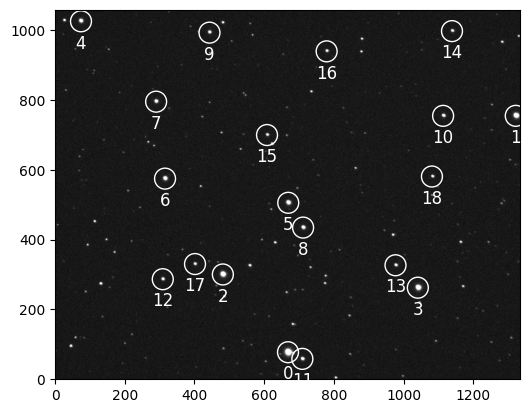

In [8]:
import matplotlib.pyplot as plt
from eloy import viz

plt.imshow(viz.z_scale(ref_data), cmap="Greys_r", origin="lower")
viz.plot_marks(*ref_coords.T, color="w", label=True, ms=30)

## Plate Solving and Target Identification

In this pipeline, the target is identified on the reference image prior to plate solving. The reference image is plate solved, and the relative aperture radii are defined before performing photometry. These steps can also be performed after photometry, but are shown here beforehand for clarity.

The process begins by defining some telescope and image properties.

In [9]:
from astropy.coordinates import SkyCoord

# known pixel size in degrees
pixel_scale = 0.62 / 3600
# size of the field-of-view
fov = ref_data.shape[1] * pixel_scale
# RA/Dec coordinates of the image
ref_header = fits.getheader(reference_image)
center = SkyCoord(ref_header["OBJCTRA"], ref_header["OBJCTDEC"], unit=("h", "deg"))

The WCS is computed using the twirl package.

In [10]:
from twirl import gaia_radecs
from twirl.geometry import sparsify
from twirl import compute_wcs

all_radecs = gaia_radecs(
    center,
    1.5 * fov,
)

# we only keep stars 0.01 degree apart from each other
all_radecs = sparsify(all_radecs, 0.01)
# we only use the n brightest stars from Gaia
wcs = compute_wcs(ref_coords[0:15], all_radecs[0:15], tolerance=10)

```{note}
We only use a small number of stars (~15) from each set to perfrom the plate solving. Increasing this number will lead to way longer processing time.
```

It is good practice to verify the WCS solution by overlaying the queried star positions on the image.

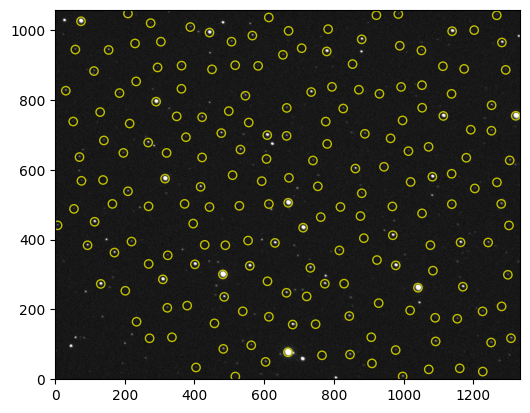

In [11]:
import matplotlib.pyplot as plt
from eloy import viz

# plotting to check the WCS
radecs_xy = np.array(wcs.world_to_pixel_values(all_radecs))[0:1000]

plt.imshow(viz.z_scale(ref_data), cmap="Greys_r", origin="lower")
viz.plot_marks(*radecs_xy.T, color="y")

The following section demonstrates how to cross-match detected stars with a target identified by name, using astropy.

In [12]:
from astroquery.mast import Mast

# we load the wcs using the image header
stars_radec = wcs.pixel_to_world(*ref_coords.T)

# Querying the target RA/Dec
mast = Mast()
target_radec = mast.resolve_object("WASP 12")

# getting target index
target_index = int(target_radec.match_to_catalog_sky(stars_radec)[0])

logger.info(f"Target index found: {target_index}")

2025-06-20 11:55:54,118 - INFO: Target index found: 6


This approach is both simple and effective.

## Aperture Selection

Relative radii are defined here. These radii are multiplied by each image's FWHM to determine the actual aperture sizes.

In [13]:
RELATIVE_RADII = np.linspace(0.1, 5, 30)
ANNULUS = (5, 8)

The apertures are visualized on the reference image to confirm their placement.

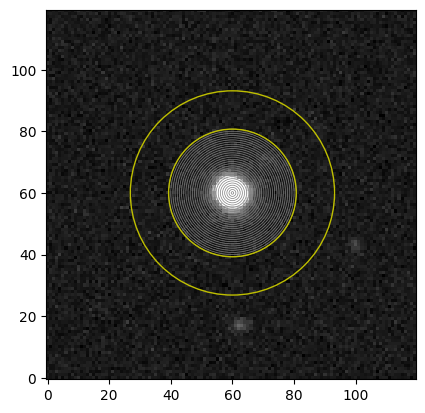

In [14]:
CUTOUT = 120
target_cutout = utils.cutout(ref_data, [ref_coords[target_index]], CUTOUT)[0]
plt.imshow(viz.z_scale(target_cutout), cmap="Greys_r", origin="lower")

for r in RELATIVE_RADII * ref_fwhm:
    circle_aperture = plt.Circle(
        (CUTOUT / 2, CUTOUT / 2), r, color="0.5", fill=False, lw=0.5
    )
    plt.gca().add_artist(circle_aperture)

for r in np.array(ANNULUS) * ref_fwhm:
    annulus_aperture = plt.Circle((CUTOUT / 2, CUTOUT / 2), r, color="y", fill=False)
    plt.gca().add_artist(annulus_aperture)

## Photometry

The photometry step follows the approach described in the [photometry tutorial](), with additional comments for clarity

In the pipeline we also added logging information but keep it commented not to overcrowded this tutorial page. In practice, these logging info are very useful to check the pipeline progress and debug any issue.

In [15]:
from skimage.transform import AffineTransform
from eloy import centroid, photometry
from astropy.time import Time
from collections import defaultdict
from pathlib import Path
from tqdm.auto import tqdm
from skimage.transform import warp
from eloy.centroid import Ballet

N_STARS = 200
CUTOUT_SHAPE = (21, 21)

stack = np.zeros_like(ref_data)
data = defaultdict(list)
cnn = Ballet()

logger.info("Starting full reduction")

for i, file in enumerate(tqdm(images)):
    filename = Path(file).name
    # logger.info(f"Processing {filename} ({i + 1}/{len(images)})")

    # calibration and FWHM
    calibrated_data, coords, fwhm, regions = calibration_sequence(file)
    # logger.info(f"{len(coords)} stars detected")
    # logger.info(f"FWHM: {fwhm:.2f} pixels")

    # skip images with too few stars
    if len(coords) < 10:
        # logger.warning(f"{filename} discarded")
        continue

    # alignment
    R = alignment.rotation_matrix(
        coords[0:N_STARS_ALIGN], ref_coords[0:N_STARS_ALIGN], ref_reference
    )
    transform = AffineTransform(R).inverse
    aligned_coords = transform(ref_coords)[0:N_STARS]
    dx, dy = np.median(ref_coords[0:N_STARS] - aligned_coords, 0)
    # logger.info(f"(X,Y) shift: ({dx:.2f}, {dy:.2f}) pixels")

    # centroiding
    centroid_coords = centroid.ballet_centroid(calibrated_data, aligned_coords, cnn)
    # aperture photometry
    apertures_radii = RELATIVE_RADII * fwhm
    flux = photometry.aperture_photometry(
        calibrated_data, centroid_coords, apertures_radii
    )
    # annulus background correction
    annulus_radii = np.max(apertures_radii), 8 * fwhm
    aperture_area = np.pi * apertures_radii**2
    bkg = photometry.annulus_sigma_clip_median(
        calibrated_data, centroid_coords, *annulus_radii
    )
    bkg = bkg[:, None] * aperture_area[None, :]

    # peaks
    peaks = np.nanmax(
        utils.cutout(calibrated_data, aligned_coords, (25, 25)), axis=(1, 2)
    )

    # getting data
    header = fits.open(file)[0].header
    data["bkg"].append(bkg)
    data["fluxes"].append(flux)
    data["fwhm"].append(fwhm)
    data["time"].append(Time(parser.parse(header["DATE-OBS"])).jd)
    data["dx"].append(dx)
    data["dy"].append(dy)
    data["sky"].append(np.mean(bkg / aperture_area[None, :]))
    data["airmass"].append(header.get("AIRMASS", np.nan))
    data["peak"].append(peaks)
    data["stars_in_exp"].append(len(coords))
    data["aperture_radii"].append(apertures_radii)
    data["annulus_radii"].append(annulus_radii)

    # Aligning the data to the reference to build the stack
    aligned_data = warp(calibrated_data, transform, cval=np.median(calibrated_data))
    stack += aligned_data

for k, v in data.items():
    data[k] = np.array(v)

logger.info("Reduction completed")

2025-06-20 11:55:54,862 - INFO: Starting full reduction


  0%|          | 0/336 [00:00<?, ?it/s]

2025-06-20 11:57:05,872 - INFO: Reduction completed


A stacked image is created from the data, and visualized below.

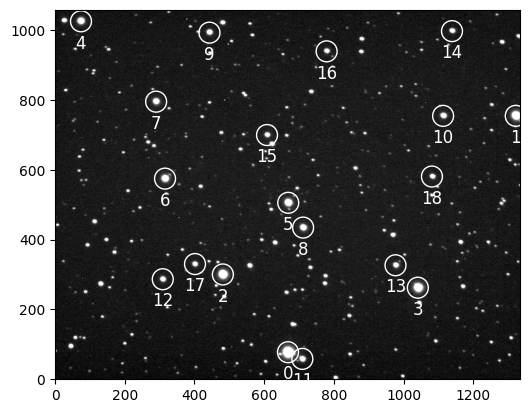

In [16]:
import matplotlib.pyplot as plt
from eloy import viz

plt.imshow(viz.z_scale(stack), cmap="Greys_r", origin="lower")
viz.plot_marks(*ref_coords.T, color="w", label=True, ms=30)

## Differential Photometry

Differential photometry is performed as described in the [photometry tutorial]().

In [17]:
from eloy import flux

# we remove the background from the annulus aperture
fluxes = (data["fluxes"] - data["bkg"]).T

# here we apply any kind of masking we want, for example
mask = data["sky"] < 300

# and perform differential photometry
diffs, weights = flux.auto_diff(fluxes[:, :, mask], target_index)

# finally we find the 'optimal' aperture for our target
best_aperture = flux.optimal_flux(diffs[:, target_index])
diff = diffs[best_aperture, target_index]

# for plotting
masked_time = data["time"][mask]

/Users/lionelgarcia/code/eloy/src/eloy/flux.py:97: RuntimeWarning: invalid value encountered in divide
  artificial_light_curve = (sub @ weighted_fluxes) / np.expand_dims(
/Users/lionelgarcia/code/eloy/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/lionelgarcia/code/eloy/src/eloy/utils.py:135: RuntimeWarning: Mean of empty slice
  return np.nanmean(


The resulting transit light curve is shown below.

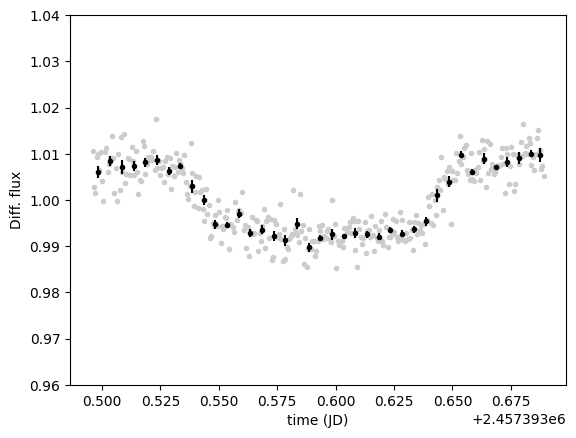

In [18]:
idxs = utils.index_binning(masked_time, 0.005)
binned_time = [masked_time[i].mean() for i in idxs]
binned_diff = [diff[i].mean() for i in idxs]
binned_error = [diff[i].std() / np.sqrt(len(i)) for i in idxs]

plt.plot(masked_time, diffs[best_aperture, target_index, :], ".", c="0.8")
plt.errorbar(binned_time, binned_diff, yerr=binned_error, fmt=".", c="k")
plt.ylim(0.96, 1.04)
plt.xlabel("time (JD)")
_ = plt.ylabel("Diff. flux")

## Plots

Several plots are commonly used when reporting results to the scientific community. Some of these are presented below.

### Stack PSF and Apertures

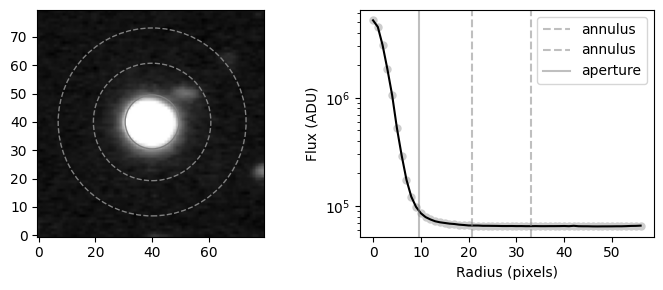

In [19]:
import numpy as np


def radial_profile(data, center):
    # https://stackoverflow.com/questions/21242011/most-efficient-way-to-calculate-radial-profile
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0]) ** 2 + (y - center[1]) ** 2)
    r = r.astype(int)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile


CUTOUT = 80
fig, ax = plt.subplots(1, 2, figsize=(7, 3), width_ratios=(1, 1))
target_cutout = utils.cutout(stack, [ref_coords[target_index]], CUTOUT)[0]
ax[0].imshow(viz.z_scale(target_cutout), cmap="Greys_r", origin="lower")
profile = radial_profile(target_cutout, [CUTOUT / 2, CUTOUT / 2])
ax[1].plot(profile, ".", c="0.8", ms=10)
ax[1].plot(profile, c="k")
aperture = ref_fwhm * RELATIVE_RADII[best_aperture]
circle_aperture = plt.Circle(
    (CUTOUT / 2, CUTOUT / 2), aperture, color="0.5", fill=False
)
ax[0].add_artist(circle_aperture)
annulus = np.array(ANNULUS) * ref_fwhm
for a in annulus:
    circle_aperture = plt.Circle(
        (CUTOUT / 2, CUTOUT / 2), a, color="0.5", fill=False, ls="--"
    )
    ax[0].add_artist(circle_aperture)
    ax[1].axvline(a, color="0.5", label="annulus", alpha=0.5, ls="--")

plt.axvline(aperture, color="0.5", label="aperture", alpha=0.5)
ax[1].set_yscale("log")
plt.xlabel("Radius (pixels)")
plt.ylabel("Flux (ADU)")
plt.legend()
plt.tight_layout()

### Comparison Star Light Curves

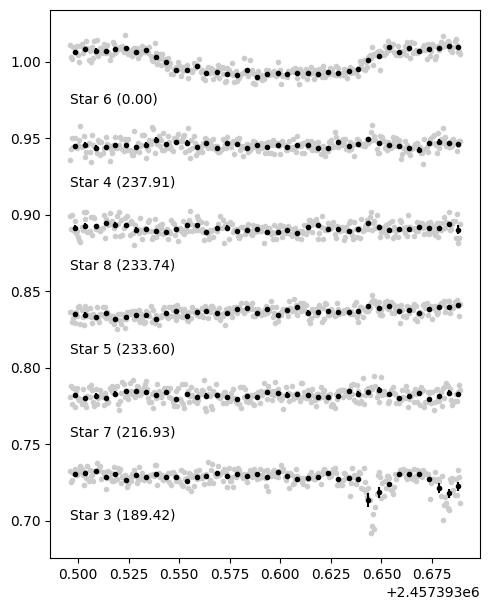

In [20]:
best_weights = weights[best_aperture]
comparison_stars = np.flatnonzero(best_weights > 0.0)
comparison_stars = sorted(comparison_stars, key=lambda i: best_weights[i], reverse=True)

offset = np.std(diff) * 7
plt.figure(figsize=(5, 1 * (1.2 + len(comparison_stars))))

for i, star in enumerate([target_index, *comparison_stars]):
    plt.plot(masked_time, diffs[best_aperture, star] - offset * i, ".", color="0.8")
    binned_time = [masked_time[i].mean() for i in idxs]
    binned_diff = [diffs[best_aperture, star][i].mean() for i in idxs]
    binned_error = [diffs[best_aperture, star][i].std() / np.sqrt(len(i)) for i in idxs]
    plt.errorbar(
        binned_time, binned_diff - offset * i, yerr=binned_error, fmt=".", c="k"
    )
    plt.text(
        masked_time[0],
        1 - offset * (i + 0.5),
        f"Star {star} ({best_weights[star]:.2f})",
        ha="left",
    )

plt.tight_layout()

### Instrumental and Atmospheric Signals

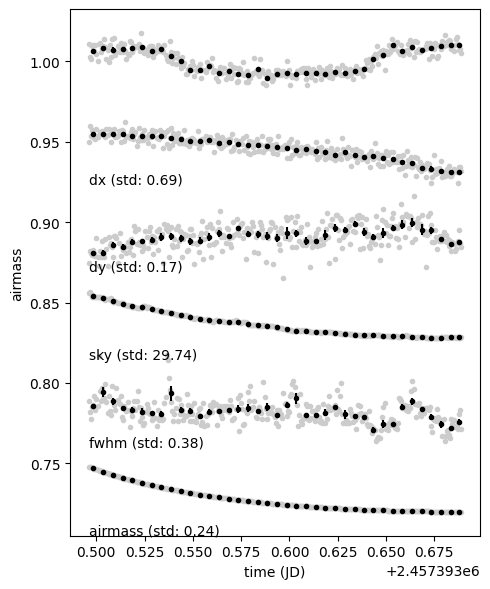

In [21]:
plt.figure(figsize=(5, 1 * (1 + 5)))

plt.plot(masked_time, diffs[best_aperture, target_index, :], ".", c="0.8")
binned_diff = [diff[i].mean() for i in idxs]
binned_error = [diff[i].std() / np.sqrt(len(i)) for i in idxs]
plt.errorbar(binned_time, binned_diff, yerr=binned_error, fmt=".", c="k")
target_std = np.std(diffs[best_aperture, target_index])
offset = 7 * target_std

for i, syst in enumerate(["dx", "dy", "sky", "fwhm", "airmass"]):
    signal = data[syst] - np.mean(data[syst])
    signal /= np.std(signal)
    signal = 1 + signal * target_std
    plt.plot(masked_time, signal - offset * (i + 1), ".", color="0.8")
    binned_time = np.array([masked_time[i].mean() for i in idxs])
    binned_syst = np.array([signal[i].mean() for i in idxs])
    binned_error = np.array([signal[i].std() / np.sqrt(len(i)) for i in idxs])
    plt.errorbar(
        binned_time, binned_syst - offset * (i + 1), yerr=binned_error, fmt=".", c="k"
    )
    plt.xlabel("time (JD)")
    plt.ylabel(syst)
    plt.text(
        masked_time[0],
        1 - offset * (i + 1 + 0.4),
        f"{syst} (std: {np.std(data[syst]):.2f})",
        ha="left",
    )

plt.tight_layout()